In [1]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907057 sha256=2b6497078741ae3ddd69be3677bd820e6c7cbee5233e1c1c7457c2e015db171e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3hdehqcy/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

**Create tokenizers**

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

**Create Fields**

In [6]:
# English to German

SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


**Download traina nd test data**

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 904kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 276kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 264kB/s]


**Build Vocabulary**

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

**Set device, batch size, and create iterators**

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x : len(x.src),
    device = device)

### **Encoder**

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.GRU(embed_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(2*enc_hid_dim, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # src = [src len, batch size]
        # embedding = [src len, batch size, embed dim]
        embedding = self.dropout(self.embedding(src))
        
        # output = [src len, batch size, enc hidden dim * no of directions]
        # hidden = [n layers * no of directions, batch size, enc hidden dim]
        outputs, hidden = self.rnn(embedding)

        # print("Embed shape:", embedding.shape)
        # print("Rnn output shape: ",  outputs.shape)
        # print("Rnn hidden shape: ",  hidden.shape) 

        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...] for 
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN 
        # hidden = [batch size, decoder hidden dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))

        # print("Fc output shape:", hidden.shape)

        return outputs, hidden




In [12]:
# Testing
enc = Encoder(input_dim=32, 
              embed_dim=256, 
              enc_hid_dim=512, 
              dec_hid_dim=512, 
              dropout=0.1)
enc

Encoder(
  (embedding): Embedding(32, 256)
  (rnn): GRU(256, 512, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [13]:
# Testing shapes
e, h = enc.forward(torch.zeros(12, 32).to(torch.int64)) 
e.size()
# embedding: [sentence_length, batch_size, embed_dim]
# output: [sentence_len, batch_size, 2 * enc_hid_dim]
# hidden: [ batch_size, enc_hidden_dim]

torch.Size([12, 32, 1024])

In [14]:
h[0].size()

torch.Size([512])

In [15]:
# h[-1, :, :].size()

### **Attention Block**

In [16]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim*2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, encoder_outputs, hidden):
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]

        src_len = encoder_outputs.shape[0]
        # print("In attention model ---")
        # print("encoder_outputs: ", encoder_outputs.shape)
        # print("hidden: ", hidden.shape)
        

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src len, dec hid dim]
        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        # [batch, src len, 512] + [batch, src len, 1024] ==> concat along dim 2
        
        # energy is similarity between hidden vectors and encoded vectors
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src len, dec_hid_dim]

        attention = self.v(energy).squeeze(2) # squeeze unwanted dims
        # attention = [batch size, src len]

        return F.softmax(attention, dim=1) 


In [17]:
# enc = Encoder(input_dim=32, 
#               embed_dim=256, 
#               enc_hid_dim=512, 
#               dec_hid_dim=512, 
#               dropout=0.1)


In [18]:
outputs, hidden = enc.forward(torch.zeros(12, 32).to(torch.int64)) 
outputs.size(), hidden.size()

(torch.Size([12, 32, 1024]), torch.Size([32, 512]))

In [19]:
# only for testing, assume decoder st is same as enc hidden (same dims)
s_hidden = hidden 
s_hidden.size()

torch.Size([32, 512])

In [20]:
# We need this to be added to outputs, which are of size [12, 32, 1024].. restructuring..

tt = s_hidden.unsqueeze(1)
print(tt.size())

rr = tt.repeat(1, 12, 1)
print(rr.size())

outputs.permute(1, 0, 2).size()

torch.Size([32, 1, 512])
torch.Size([32, 12, 512])


torch.Size([32, 12, 1024])

### **Decoder**

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.attention = attention
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim) # encoder is bidirectional
        self.fc_out = nn.Linear( (enc_hid_dim * 2) + emb_dim + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # this hidden is from the decoder hidden output 
        # input is coming as single word, make it as a batch
        # input = [batch size]
        input = input.unsqueeze(0)
        # input = [1, batch size]

        # print("In decoder ---")
        # print("Input shape:", input.shape)
        # print("hidden shape:", hidden.shape)
        # print("Encoder outputs:", encoder_outputs.shape)

        embedding = self.dropout(self.embedding(input))
        # embedding = [1, batch size, emb dim]
        
        attn = self.attention(encoder_outputs, hidden) #        
        # print("Attn shape: ", attn.shape)

        attn = attn.unsqueeze(1)
        # attn = [batch size, 1, src len] # 1 is output from attn

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src len, enc hidden dim * 2]

        # bmm is matrix mult
        weighted = torch.bmm(attn, encoder_outputs)
        # weighted = [batch sizze, 1, enc hidden dim*2]

        # print("embedding: ", embedding.shape)
        # print("weighted: ", weighted.shape)

        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedding, weighted), dim=2)
        # rnn_input = [1, batch size, end hidden dim * 2 + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # Need to squeeze tensors back, so that extra dim is removed before sending to fc
        embedding = embedding.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedding), dim=1))

        return prediction, hidden.squeeze(0), attn.squeeze(1)


### **Seq2Seq Model**

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### **Define Parameters**

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [24]:
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

**Init weights**

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0,std=0.01)
        else:
            nn.init.constant_(param.data, 0)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(7855, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=7855, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,036,783 trainable parameters


**Define optimizer, loss**

In [27]:
optimizer = optim.Adam(model.parameters())

In [28]:
# ignore padding tokens
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### **Train Loop**

In [29]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### **Test Loop**

In [30]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [31]:
# Timing function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### **Train the model**

In [32]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 54s
	Train Loss: 5.181 | Train PPL: 177.816
	 Val. Loss: 4.847 |  Val. PPL: 127.324
Epoch: 02 | Time: 0m 54s
	Train Loss: 4.118 | Train PPL:  61.452
	 Val. Loss: 4.157 |  Val. PPL:  63.869
Epoch: 03 | Time: 0m 54s
	Train Loss: 3.326 | Train PPL:  27.826
	 Val. Loss: 3.531 |  Val. PPL:  34.142
Epoch: 04 | Time: 0m 54s
	Train Loss: 2.758 | Train PPL:  15.775
	 Val. Loss: 3.285 |  Val. PPL:  26.702
Epoch: 05 | Time: 0m 54s
	Train Loss: 2.340 | Train PPL:  10.384
	 Val. Loss: 3.154 |  Val. PPL:  23.421
Epoch: 06 | Time: 0m 54s
	Train Loss: 2.000 | Train PPL:   7.389
	 Val. Loss: 3.134 |  Val. PPL:  22.969
Epoch: 07 | Time: 0m 54s
	Train Loss: 1.763 | Train PPL:   5.832
	 Val. Loss: 3.175 |  Val. PPL:  23.933
Epoch: 08 | Time: 0m 54s
	Train Loss: 1.585 | Train PPL:   4.879
	 Val. Loss: 3.138 |  Val. PPL:  23.052
Epoch: 09 | Time: 0m 54s
	Train Loss: 1.443 | Train PPL:   4.235
	 Val. Loss: 3.202 |  Val. PPL:  24.576
Epoch: 10 | Time: 0m 54s
	Train Loss: 1.343 | Train PPL

In [33]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.138 | Test PPL:  23.057 |


### **Inference**
Taken from https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

In [39]:


def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        # encoder_outputs, hidden = model.encoder(src_tensor, src_len)
        encoder_outputs, hidden = model.encoder(src_tensor)

    # mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            # output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:] , attentions[:len(trg_tokens)-1]

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [50]:
example_idx = 43

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'beautiful', 'bride', 'walking', 'on', 'a', 'sidewalk', 'with', 'her', 'new', 'husband', '.']
trg = ['eine', 'schöne', 'braut', 'geht', 'auf', 'einem', 'gehweg', 'mit', 'ihrem', 'neuen', 'ehemann', '.']


In [51]:
# translation, attention = translate_sentence(src, SRC, TRG, model, device)
translation, attention = translate_sentence(src, SRC, TRG, model, device)


print(f'predicted trg = {translation}')
#'a', 'beautiful', 'bride', 'goes', 'with', 'one', 'walkway', 'with', 'her', 'new', 'new'


predicted trg = ['eine', 'schöne', 'braut', 'geht', 'mit', 'einem', 'gehweg', 'mit', 'ihrem', 'neuen', 'neuen', '.', '<eos>']


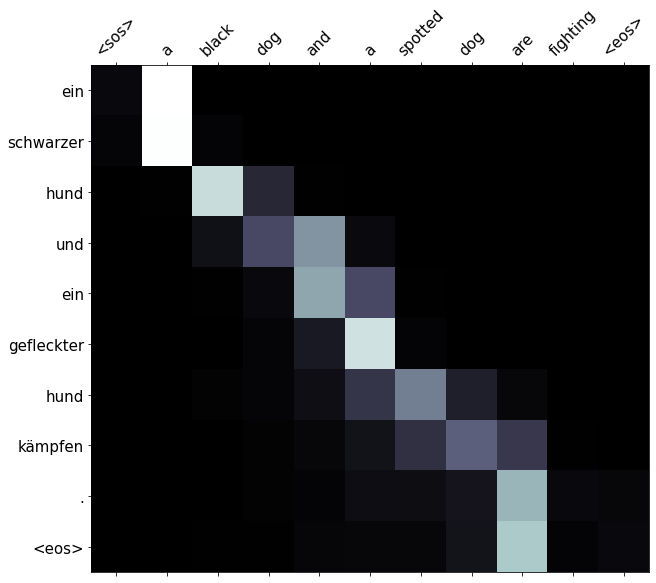

In [47]:
display_attention(src, translation, attention)

**On Test data**

In [48]:
example_idx = 90

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['a', 'woman', 'with', 'pink', 'hair', 'dressed', 'in', 'black', 'talks', 'to', 'a', 'man', '.']
trg = ['eine', 'schwarz', 'gekleidete', 'frau', 'mit', 'rosa', 'haaren', 'spricht', 'mit', 'einem', 'mann', '.']


predicted trg = ['eine', 'frau', 'mit', 'rosa', 'haaren', 'in', 'schwarz', 'spricht', 'mit', 'einem', 'mann', '.', '<eos>']


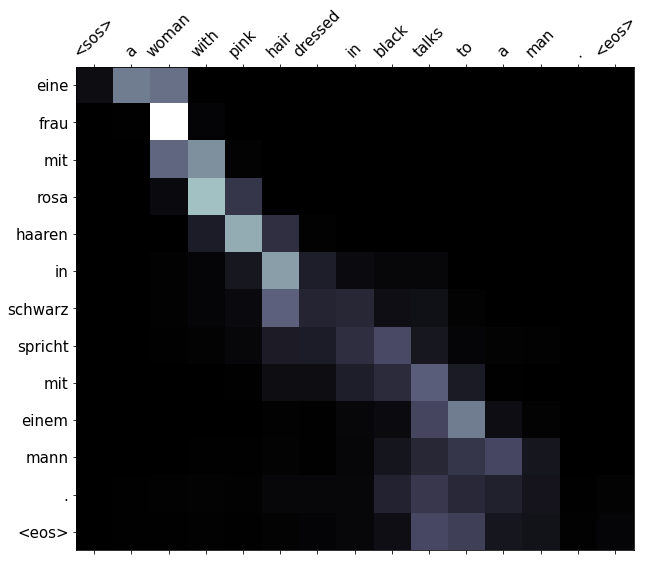

In [49]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)
# a ',' woman ',' with ',' pink ',' hair ',' in ',' black ',' speaks', 'with', 'one', 'man'


### **BLEU**

In [55]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 1.2MB 20.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [56]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

ImportError: ignored